## Preprocess data/ build features for RNN/LSTM/GRU

In [26]:
import os
import copy 
import numpy as np
import torch.nn as nn
import torch
import csv
import itertools
import operator
import nltk
import sys
from datetime import datetime


# keras libs
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

# import pandas for data processing
import pandas as pd

# import lib for plot
import matplotlib.pyplot as plt

## Read train data to pandas framework

In [78]:
# define path to data files
data_path = "/Users/georgyguryev/Documents/repos/6.867/PLAsTiCC-Astronomical-Classification/data/class_data/"

# define train time series and static data
train_ts_fname = "class_training_set.csv"
train_md_fname = "class_training_set_meta.csv"

test_ts_fname = "class_test_set.csv"
test_md_fname = "class_test_set_meta.csv"

# read csv files 
train_time_series = pd.read_csv(data_path + train_ts_fname)
train_meta_data   = pd.read_csv(data_path + train_md_fname)

test_time_series = pd.read_csv(data_path + test_ts_fname)
test_meta_data   = pd.read_csv(data_path + test_md_fname)


## Generate features

In [79]:
N_pass = 6
N_obj  = train_time_series['object_id'].unique().shape[0]
N_raw  = train_time_series.shape[0]

# get maximum length of time series
max_Length = train_time_series['object_id'].value_counts().max();

# form a list of unique objects
Obj_list   = train_time_series['object_id'].unique()

print(Obj_list)


def generate_features(data, n_passbd = 6):
   
    # define type of aggregation parameters
    aggs = {'flux':['mean', 'std'],
           'flux_err': ['mean','std']
           }
    
    # aggregate data for statistics
    obj_stat = data.groupby(['object_id', 'passband']).agg(aggs)

    return obj_stat


def sigmoid (x):
    output = 1./ (1. + np.exp(x))
    return output
    
    
# call statistics generator
obj_stat = generate_features(train_time_series)

# convert DataFrame to np array
stat_data = obj_stat.values

# extract flux data [mean, std]
flux_mean = stat_data[:,0].T.reshape((N_obj,N_pass))
flux_std  = stat_data[:,1].T.reshape((N_obj,N_pass))

# extract flux error [mean, std]
flux_mean_err = stat_data[:,2].T.reshape((N_obj,N_pass))
flux_std_err  = stat_data[:,3].T.reshape((N_obj,N_pass))

# generate column names
flux_mean_col = ['flux' + '_' + str(band) for band in range(N_pass)]
flux_std_col  = ['flux_std' + '_' + str(band) for band in range(N_pass)]

flux_err_mean_col = ['flux_err_' + '_' + str(band) for band in range(N_pass)]
flux_err_std_col  = ['flux_err_std' + '_' + str(band) for band in range(N_pass)]

# create datastructures 
df_flux_mean = pd.DataFrame(np.sign(flux_mean) * np.log(abs(flux_mean)))
df_flux_std  = pd.DataFrame(np.sign(flux_std) * np.log(abs(flux_mean)))

df_flux_err_mean = pd.DataFrame(np.sign(flux_mean_err) * np.log(abs(flux_mean_err)))
df_flux_err_std  = pd.DataFrame(np.sign(flux_std_err) * np.log(abs(flux_std_err)))

# label data structures
df_flux_mean.columns = flux_mean_col
df_flux_std.columns  = flux_std_col
df_flux_err_mean.columns = flux_err_mean_col
df_flux_err_std.columns  = flux_err_std_col

# merge 
frames = pd.concat([df_flux_mean, df_flux_std, df_flux_err_mean, df_flux_err_std], axis = 1)


[      713       730       745 ... 130762946 130772921 130779836]


## Produce time series input for RNN 


In [80]:
def create_series_features(raw_train_series, stat_train_series):
    
    # allocate memory for new data structure
    series_features    = copy.deepcopy(raw_train_series)
    
    # allocate memory for output feature vector
    resulting_features = np.zeros((N_obj * max_Length, 4* N_pass + 12))
    resulting_targets  = np.zeros((N_obj * max_Length,1))
    
#     print (resulting_features)
    
    # prepare label list for reshuffling
    labels = ["object_id", "mjd", "detected", "passband", "flux", "flux_err"]
    
    series_features = series_features[labels]
    
#     for i in range(round(N_obj / 10)):
    for i in range(N_obj):
        
        # select all observations for a current object
        current_observ = series_features.loc[series_features['object_id'] == Obj_list[i]].values
        
        # select statistics vector for current object
        current_flux_features = stat_train_series.iloc[i].values.T
                        
        cur_N_raw = current_observ.shape[0]

        i_shift = max_Length * i
                
        # fill in the target metadata
#         resulting_targets[i_shift: i_shift + max_Length] = np.ones((max_Length,1)) * target_meta_data[i]
        
        for j in range(cur_N_raw):
            
            # get current observation vector for i-th object
            current_raw_vetor = np.reshape(current_observ[j,:], (6,1))
                                    
            # get current observation bandwidth
            current_passband = int(current_raw_vetor[3])
                
            # update flux value for the current bandwidth
            current_flux_features[current_passband] = np.sign(current_raw_vetor[4]) *  np.log(np.abs(current_raw_vetor[4]))

            # update flux error for the current bandwidth
            current_flux_features[current_passband + 2 * N_pass] = np.sign(current_raw_vetor[5]) * np.log(np.abs(current_raw_vetor[5]))

            
            
            # concatenate static and dynamic features
            resulting_features[i_shift + j,:] = np.concatenate((current_raw_vetor[0:3].T, np.reshape(current_flux_features, (1,33))), axis=1)

        if ( i % 1000 == 999):    
            print(i * 100 / N_obj)
            
    # return resulting features
    return resulting_features
        
# target_meta_data = train_meta_data['target']
# X_train, Y_train = create_series_features(train_time_series, train_static_data, target_meta_data)
# X_train.shape


## dkf;ksd;flks;d

In [81]:
# extract target classes
Y_train = pd.get_dummies(train_meta_data['target'])

# define weight vector for unique label classes
# weights = {x:1 for x in np.unique(target)}

# remove nans/nulls for galactic redshift/dist
train_mask = train_meta_data['distmod'].isnull().values

# 
train_meta_data['distmod'].fillna(0, inplace=True)

# # reweigth galaxies
# weights[15] = 2
# weights[64] = 2

train_meta_data.head()

# remove target and hostgal_specz columns from metadata
remove_cols = ['hostgal_specz','target','object_id']
for c in remove_cols:
    if c in train_meta_data.columns:
        del train_meta_data[c]



# call function        
# X_train = create_series_features(train_time_series, frames, train_meta_data)
    
# X_train_df = pd.DataFrame(X_train)


In [82]:
train_static_data = pd.concat([frames,train_meta_data], sort='False', axis=1)
print(train_static_data.shape)


# construct features
X_train = create_series_features(train_time_series, train_static_data)


# reshape data for rnn input
n_rows = X_train.shape[0]

X_train = np.reshape(X_train, (round(n_rows / 352),352,36))

X_train.shape

(5258, 33)
18.99961962723469
38.01825789273488
57.03689615823507
76.05553442373527
95.07417268923545


(5258, 352, 36)

# Create and Train RNN

In [83]:
# instantiate rnn for simple test
n_hidden = 36
n_input  = 36
n_categories = 14
n_sequence = 352



In [84]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import Dropout
from keras.layers import LSTM
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization


In [85]:

def multi_weighted_logloss(y_true, y_preds):
    """
    this function implements a multi logloss 
    """
    print(y_true)
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
#     y_ohe = pd.get_dummies(y_true)
    y_ohe = y_true
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = K.clip(y_p, 1e-15, 1 - 1e-15)
    # Transform to log
    y_p_log = K.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = K.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = K.sum(y_ohe ,axis=0)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 352, 24)           5856      
_________________________________________________________________
batch_normalization_22 (Batc (None, 352, 24)           96        
_________________________________________________________________
dropout_21 (Dropout)         (None, 352, 24)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 24)                4704      
_________________________________________________________________
batch_normalization_23 (Batc (None, 24)                96        
_________________________________________________________________
dropout_22 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 14)                350       
Total para

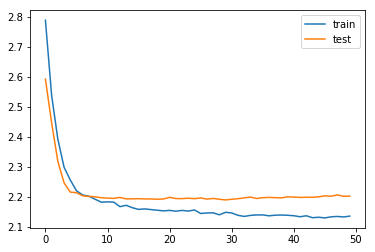

In [86]:

# split training data on two sets
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.2, random_state = 4)

# define RNN architecture
model = Sequential()


model.add(LSTM(24, batch_input_shape=(None, 352, 36), return_sequences=True))

model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(24))
model.add(BatchNormalization())

model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# fit network
history = model.fit(train_x, train_y, epochs=50, batch_size=40, validation_data=(test_x, test_y), verbose=2, shuffle=False)


# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

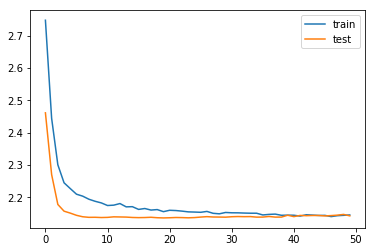

In [49]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [65]:
Y_predict = model.predict(test_x)

In [75]:
Y_predict_df = pd.DataFrame(Y_predict)
type(Y_predict_df)

test_y_df = pd.DataFrame(test_y)

Y_predict_df.to_csv('/Users/georgyguryev/Documents/repos/RNN_predictions.csv')
test_y_df.to_csv('/Users/georgyguryev/Documents/repos/RNN_true_labels.csv')

In [52]:
plot_model(model, to_file=data_folder+'model_plot.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'matplotlib.pyplot' has no attribute 'plot_model'